# 1 - 线性回归

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import random

## 1.1 - 人造数据集

In [2]:
def synthetic_data(w, b, num_examples):
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [3]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([-0.7358, -1.0999]) 
label: tensor([6.4616])


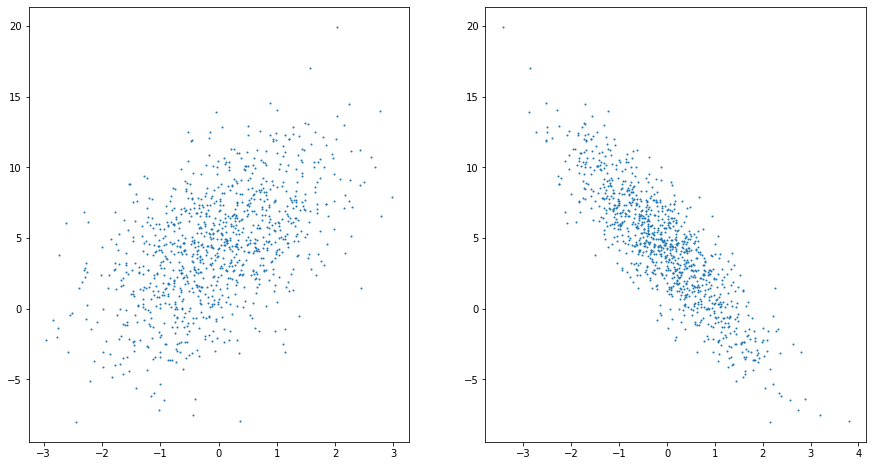

In [4]:
_, axe = plt.subplots(1, 2, figsize = (15, 8))
axe[0].scatter(features[:, 0].detach().numpy(), labels.detach().numpy(), s = 1)
axe[1].scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), s = 1)

## 1.2 - 生成小批量数据 

In [5]:
def data_iter(batch_size, features ,labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i : min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]
        
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.7559, -0.9778],
        [ 0.6302,  0.3226],
        [-0.6591,  0.4135],
        [ 1.4232, -1.0098],
        [-0.2575, -0.4160],
        [ 1.7565,  1.2804],
        [-0.4454,  3.1911],
        [ 0.3147, -0.7463],
        [ 0.7723,  0.8874],
        [-1.4440,  1.0587]]) 
 tensor([[ 6.0165],
        [ 4.3550],
        [ 1.4779],
        [10.4889],
        [ 5.0993],
        [ 3.3565],
        [-7.5468],
        [ 7.3535],
        [ 2.7314],
        [-2.3029]])


## 1.3 - 定义初始模型

In [6]:
w = torch.normal(0, 0.01, size = (2, 1), requires_grad = True)
b = torch.zeros(1, requires_grad = True)

def linreg(X, w, b):
    return torch.matmul(X, w) + b

def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

## 1.4 - 训练过程

In [7]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch{epoch + 1}, loss{float(train_l.mean()):f}')

epoch1, loss0.030227
epoch2, loss0.000108
epoch3, loss0.000051


In [8]:
print(f'w的估计误差：{true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b - b}')

w的估计误差：tensor([7.4637e-04, 6.6280e-05], grad_fn=<SubBackward0>)
b的估计误差：tensor([0.0005], grad_fn=<RsubBackward1>)


# 2 - 简洁实现

In [12]:
from torch.utils import data

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [18]:
def load_array(data_arrays, batch_size, is_train = True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle = is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

next(iter(data_iter))

[tensor([[ 1.7139, -0.9105],
         [ 0.1066,  1.2281],
         [-2.5644,  0.5359],
         [ 0.8186,  0.7168],
         [-1.3504,  2.8044],
         [ 0.1492,  0.1373],
         [-1.1713, -0.1615],
         [-0.9148,  0.1568],
         [-1.0713, -0.9552],
         [-1.6404,  0.6854]]),
 tensor([[10.7196],
         [ 0.2459],
         [-2.7419],
         [ 3.3980],
         [-8.0490],
         [ 4.0220],
         [ 2.4106],
         [ 1.8451],
         [ 5.3108],
         [-1.4124]])]

In [20]:
from torch import nn
net = nn.Sequential(nn.Linear(2, 1))

net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

loss = nn.MSELoss()

trainer = torch.optim.SGD(net.parameters(), lr = 0.03)

In [21]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000200
epoch 2, loss 0.000102
epoch 3, loss 0.000102
